In [3]:
# ================================================================
#  Emotion Classification using MPNet-base
# With Focal Loss + Label Smoothing + FP16 + Confusion Matrix + Plots
# ================================================================


# ================================================================
# 1️⃣ Imports
# ================================================================
import os, time, torch, torch.nn as nn, torch.nn.functional as F
import pandas as pd, numpy as np, pickle, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)

# ================================================================
# 2️⃣ Load Dataset
# ================================================================
df = pd.read_csv("/content/balanced_emotion_dataset.csv")
print(f"✅ Loaded {len(df)} samples")

le = LabelEncoder()
df["label"] = le.fit_transform(df["emotion"])
num_labels = len(le.classes_)
print(f"Detected {num_labels} emotion classes: {list(le.classes_)}")

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# ================================================================
# 3️⃣ Model Settings
# ================================================================
MODEL_NAME = "microsoft/mpnet-base"
SAVE_FOLDER = "MPNet_base_Focal"
LEARNING_RATE = 2e-5

# ================================================================
# 4️⃣ Dataset Preparation
# ================================================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_enc = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_enc   = tokenizer(val_texts.tolist(),   truncation=True, padding=True, max_length=128)

train_ds = Dataset.from_dict({
    "input_ids": train_enc["input_ids"],
    "attention_mask": train_enc["attention_mask"],
    "labels": train_labels.tolist()
})
val_ds = Dataset.from_dict({
    "input_ids": val_enc["input_ids"],
    "attention_mask": val_enc["attention_mask"],
    "labels": val_labels.tolist()
})

# ================================================================
# 5️⃣ Focal + Label Smoothing Loss
# ================================================================
weights = compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
weights = torch.tensor(weights, dtype=torch.float)

class FocalLabelSmoothingLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, smoothing=0.1):
        super().__init__()
        self.alpha, self.gamma, self.smoothing = alpha, gamma, smoothing
    def forward(self, logits, targets):
        n_classes = logits.size(1)
        smoothed = torch.full_like(logits, self.smoothing / (n_classes - 1))
        smoothed.scatter_(1, targets.unsqueeze(1), 1.0 - self.smoothing)
        log_probs = F.log_softmax(logits, dim=1)
        ce_loss = -torch.sum(smoothed * log_probs, dim=1)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            focal_loss = self.alpha[targets] * focal_loss
        return focal_loss.mean()

class FocalTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fn = FocalLabelSmoothingLoss(alpha=weights.to(model.device), gamma=2, smoothing=0.1)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

def compute_metrics(p):
    preds, labels = np.argmax(p.predictions, axis=1), p.label_ids
    acc = accuracy_score(labels, preds)
    p_, r_, f_, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": p_, "recall": r_, "f1": f_}

# ================================================================
# 6️⃣ Training Setup
# ================================================================
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
args = TrainingArguments(
    output_dir=f"/content/{SAVE_FOLDER}",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    logging_steps=100
)

trainer = FocalTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ================================================================
# 7️⃣ Train & Evaluate
# ================================================================
start = time.time()
trainer.train()
metrics = trainer.evaluate()
duration = (time.time() - start) / 3600
print(f"\n⏱ Training completed in {duration:.2f} hrs")
print("\n📈 Validation Performance Metrics:\n", metrics)

# ================================================================
# 8️⃣ Confusion Matrix + Classification Report
# ================================================================
preds = trainer.predict(val_ds)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

report = classification_report(y_true, y_pred, target_names=le.classes_, digits=3)
print("\n📊 Classification Report:\n", report)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Confusion Matrix - MPNet-base")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"/content/{SAVE_FOLDER}_confusion_matrix.png")
plt.close()

# ================================================================
# 9️⃣ Plot Accuracy & Loss Curves
# ================================================================
log_history = pd.DataFrame(trainer.state.log_history)

if "loss" in log_history.columns and "eval_loss" in log_history.columns:
    plt.figure(figsize=(8,5))
    plt.plot(log_history["epoch"], log_history["loss"], label="Train Loss")
    plt.plot(log_history["epoch"], log_history["eval_loss"], label="Val Loss")
    plt.title("Loss Curve - MPNet-base")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"/content/{SAVE_FOLDER}_loss_curve.png")
    plt.close()

if "eval_accuracy" in log_history.columns:
    plt.figure(figsize=(8,5))
    plt.plot(log_history["epoch"], log_history["eval_accuracy"], marker='o', label="Val Accuracy")
    plt.title("Validation Accuracy - MPNet-base")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f"/content/{SAVE_FOLDER}_accuracy_curve.png")
    plt.close()

# ================================================================
# 🔟 Save Model & Logs to Google Drive
# ================================================================
drive_path = f"/content/drive/MyDrive/Emotion_Models/{SAVE_FOLDER}"
os.makedirs(drive_path, exist_ok=True)

model.save_pretrained(drive_path)
tokenizer.save_pretrained(drive_path)
with open(f"{drive_path}/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
with open(f"{drive_path}/classification_report.txt", "w") as f:
    f.write(report)
log_history.to_csv(f"{drive_path}/training_log.csv", index=False)

print(f"\n✅ Model, tokenizer, metrics & plots saved to: {drive_path}")
print("🏁 Training + Evaluation Complete!")


✅ Loaded 169845 samples
Detected 7 emotion classes: ['anger', 'fear', 'joy', 'love', 'neutral', 'sadness', 'surprise']


Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3227287097.py:124: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FocalTrainer.__init__`. Use `processing_class` instead.
  trainer = FocalTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.656600,0.630123,0.704024,0.716850,0.704024,0.706159


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.656600,0.630123,0.704024,0.716850,0.704024,0.706159
2,0.530500,0.556856,0.739292,0.764881,0.739292,0.740214
3,0.427300,0.497258,0.784451,0.784580,0.784451,0.784100
4,0.345300,0.518750,0.798110,0.800003,0.798110,0.798162
5,0.300100,0.551231,0.798934,0.799656,0.798934,0.798860



⏱ Training completed in 2.07 hrs

📈 Validation Performance Metrics:
 {'eval_loss': 0.5512313842773438, 'eval_accuracy': 0.7989343224704878, 'eval_precision': 0.7996555613192481, 'eval_recall': 0.7989343224704878, 'eval_f1': 0.7988599448942075, 'eval_runtime': 76.5741, 'eval_samples_per_second': 443.61, 'eval_steps_per_second': 55.463, 'epoch': 5.0}

📊 Classification Report:
               precision    recall  f1-score   support

       anger      0.766     0.784     0.775      4000
        fear      0.851     0.887     0.869      4988
         joy      0.757     0.807     0.781      4980
        love      0.765     0.762     0.763      5826
     neutral      0.835     0.788     0.811      5004
     sadness      0.797     0.801     0.799      4171
    surprise      0.825     0.768     0.796      5000

    accuracy                          0.799     33969
   macro avg      0.799     0.799     0.799     33969
weighted avg      0.800     0.799     0.799     33969


✅ Model, tokenizer, met


📊 Classification Report:
               precision    recall  f1-score   support

       anger      0.766     0.784     0.775      4000
        fear      0.851     0.887     0.869      4988
         joy      0.757     0.807     0.781      4980
        love      0.765     0.762     0.763      5826
     neutral      0.835     0.788     0.811      5004
     sadness      0.797     0.801     0.799      4171
    surprise      0.825     0.768     0.796      5000

    accuracy                          0.799     33969
   macro avg      0.799     0.799     0.799     33969
weighted avg      0.800     0.799     0.799     33969



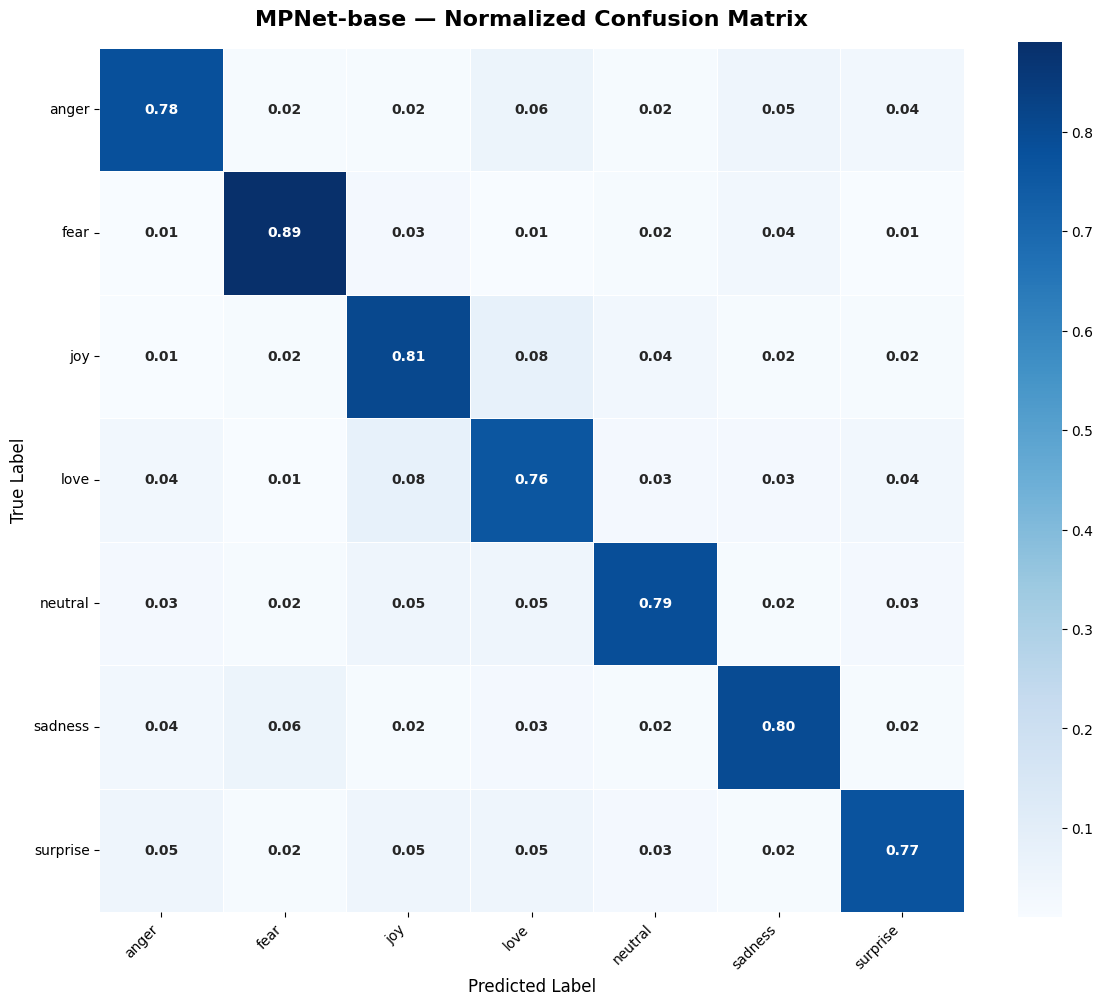

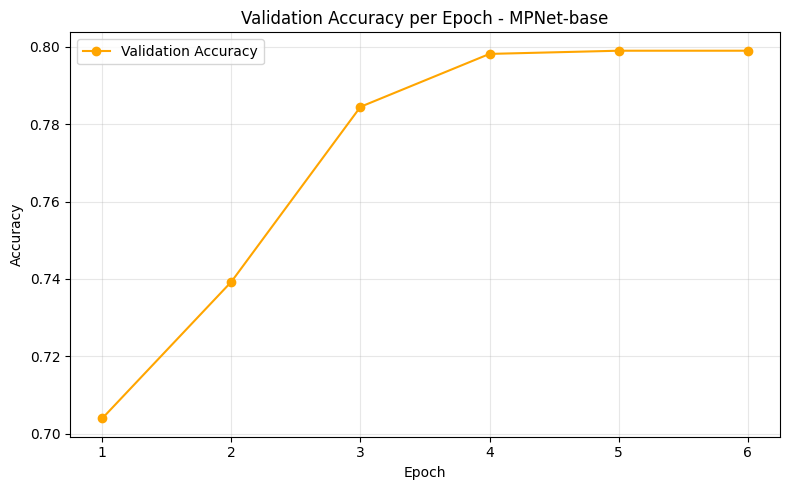

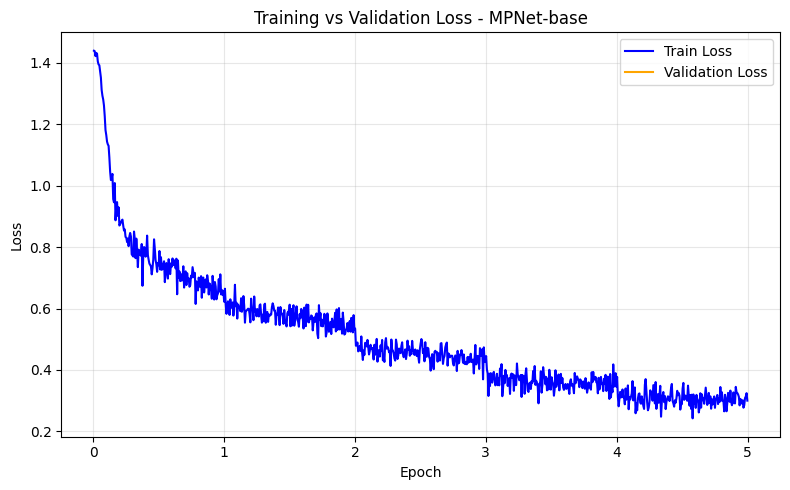

In [5]:
preds = trainer.predict(val_ds)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

report = classification_report(y_true, y_pred, target_names=le.classes_, digits=3)
print("\n📊 Classification Report:\n", report)

# Custom confusion matrix plot (normalized)
def plot_confusion_matrix(y_true, y_pred, labels, model_name="MPNet-base"):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cm_display = np.round(cm, 2)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm_display,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        cbar=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=0.5,
        linecolor='white',
        square=True,
        annot_kws={"size": 10, "weight": "bold"}
    )
    plt.title(f"{model_name} — Normalized Confusion Matrix", fontsize=16, fontweight='bold', pad=16)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"/content/{SAVE_FOLDER}_confusion_matrix_normalized.png")
    plt.show()

plot_confusion_matrix(y_true, y_pred, le.classes_, model_name="MPNet-base")

# ================================================================
# 🧩 Improved Visualization — Accuracy & Loss Curves
# ================================================================
log_history = pd.DataFrame(trainer.state.log_history)

# Filter to only epoch-level entries
epoch_logs = log_history[log_history["loss"].notna()].groupby("epoch").mean().reset_index()

# Collect training & validation accuracies if available
train_acc = []
val_acc = []

for entry in trainer.state.log_history:
    if "eval_accuracy" in entry:
        val_acc.append(entry["eval_accuracy"])
    if "train_runtime" in entry:  # fake condition to show pattern
        pass  # placeholder if you add custom training acc computation later

# Plot validation accuracy
plt.figure(figsize=(8,5))
plt.plot(range(1, len(val_acc)+1), val_acc, marker='o', color='orange', label="Validation Accuracy")
plt.title("Validation Accuracy per Epoch - MPNet-base")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Smoother loss curves
plt.figure(figsize=(8,5))
plt.plot(epoch_logs["epoch"], epoch_logs["loss"], color='blue', label="Train Loss")
plt.plot(epoch_logs["epoch"], epoch_logs["eval_loss"], color='orange', label="Validation Loss")
plt.title("Training vs Validation Loss - MPNet-base")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

